In [ ]:
# If in Colab, install Chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install "git+https://github.com/chromatix-team/chromatix.git"

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import Array
from einops import rearrange
import optax
import skimage
import matplotlib.pyplot as plt
import chromatix.functional as cx
from typing import Any

## Display Utility Functions

These cells define functions that we will use to display our results. Make sure to run these to define these functions, but otherwise you won't need to touch these functions.

In [2]:
def show_amplitude_and_phase(amplitude: np.ndarray, phase: np.ndarray):
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300)
    ax = axes[0]
    ax.imshow(amplitude, cmap="gray")
    ax.axis("off")
    ax.set_title("amplitude")
    ax = axes[1]
    ax.imshow(phase, cmap="hsv")
    ax.axis("off")
    ax.set_title("phase")

In [3]:
def show_image(image: np.ndarray):
    fig = plt.figure(dpi=150)
    ax = fig.gca()
    ax.imshow(image, cmap="gray")
    ax.axis("off")
    ax.set_title("image")

In [4]:
def plot_losses(losses: np.ndarray, num_iterations: int):
    fig = plt.figure(dpi=150)
    ax = fig.gca()
    ax.plot(np.mean(np.array(np.array_split(losses, num_iterations)), axis=1))
    ax.set_title("optimization")
    ax.set_ylabel("loss")
    ax.set_xlabel("iteration")

## Fourier Ptychography Basics

Fourier ptychography is a computational optics technique that allows you to obtain resolution higher than the diffraction limited resolution of your microscope, while also recovering the complex field (amplitude and phase) of your sample. You can extend the basic concept of Fourier ptychography for many other applications, including recovering 3D phase for multiple scattering samples ([Chowdhury et al.](https://opg.optica.org/optica/fulltext.cfm?uri=optica-6-9-1211&id=418751)).

In Fourier ptychography, you convolve the pupil of the imaging system in the Fourier plane by illuminating the sample with a tilted plane wave. As you take multiple images with different tilts, each image gives you different information about the amplitude and phase content of your sample, as well as captures higher frequencies from the sample that would otherwise be cut off by the limited pupil of the microscope (defined by its numerical aperture), as shown in the diagram below.

In order to perform Fourier ptychography, we first need to model a microscope with coherent, tilted illumination.

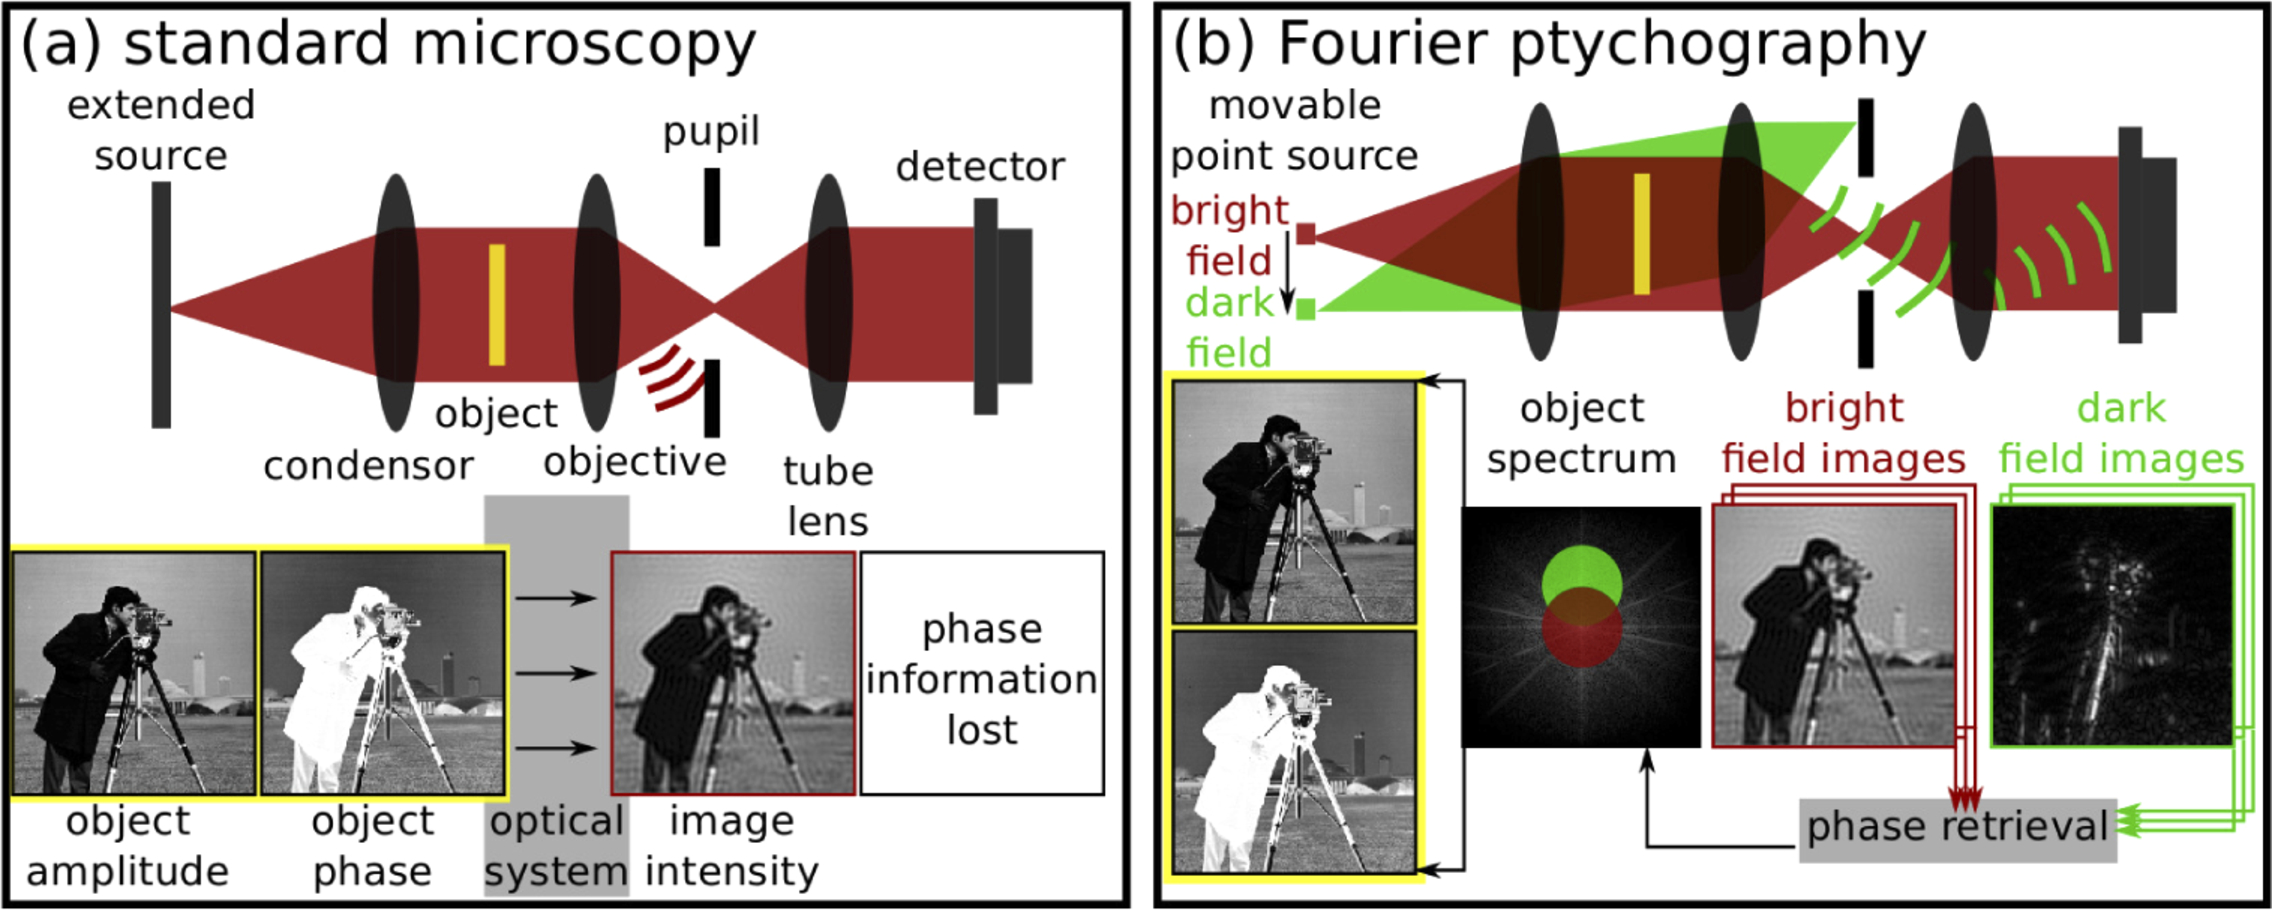

(Image from [https://doi.org/10.1364/OE.386168](https://doi.org/10.1364/OE.386168))

## Modeling Tilted Illumination Microscope

The microscope we want to model illuminates the amplitude and phase sample with tilted plane waves, relays the sample to the camera plane through a 4f system with limited NA to simulate the limited resolution of a real microscope, and then captures the intensity at the camera plane. Note that every step listed below just corresponds to just 1 or 2 lines of code using the corresponding function(s) from Chromatix!

In [5]:
def tilted_illumination_system(amplitude: Array, phase: Array, kykx: Array) -> Array:
    # 1. Start with an angled plane wave for illumination.
    # The angle is defined by a shift in Fourier (k) space, given by the kykx vector.
    # You will want to create a field with the same shape as the sample (512, 512) with
    # a pixel spacing (sampling) of 0.3 microns, and a single wavelength of
    field = cx.plane_wave(amplitude.shape, 0.3, 0.532, 1.0, kykx=kykx)
    # 2. Apply the amplitude of the sample to the incoming illumination field.
    field = cx.amplitude_change(field, amplitude)
    # 3. Apply the phase of the sample to the incoming field.
    field = cx.phase_change(field, phase)
    # 4. Define a 4f system to relay the illuminated sample to the camera plane!
    # You will want to use the same focal length for both lenses in this demo (1.8e3 microns),
    # with a refractive index of 1.33 and an NA in the pupil plane of 0.3.
    field = cx.ff_lens(field, 1.8e3, 1.33)
    field = cx.ff_lens(field, 1.8e3, 1.33, NA=0.3)
    # 5. Return the intensity of the field at the camera plane, since we measure intensity.
    return field.intensity

Next, we'll need to create a "sample" that we can pretend to measure with tilted illuminations. Here we'll use some default datasets from skimage.

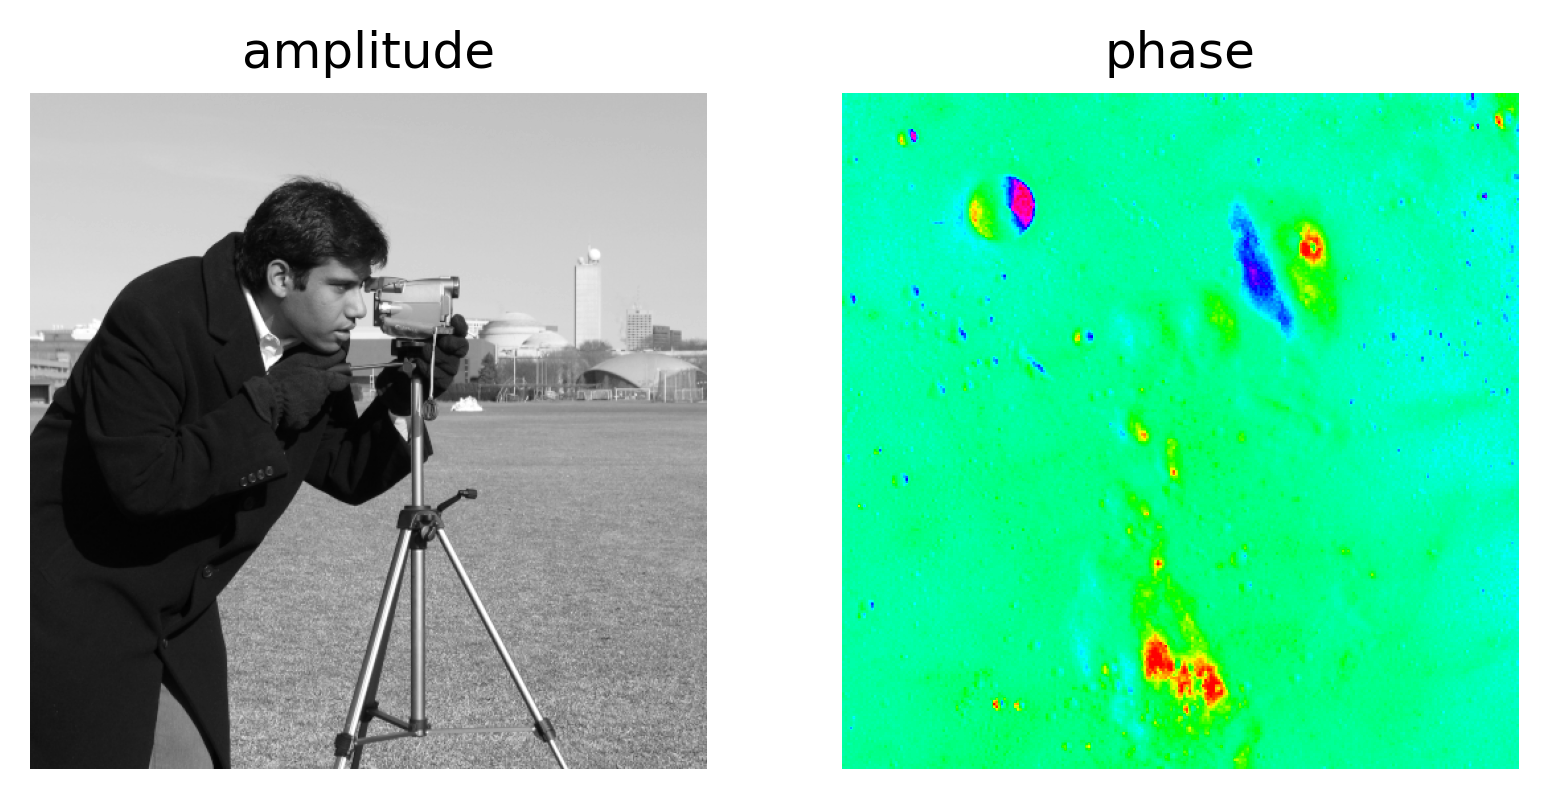

In [6]:
amplitude = skimage.data.camera().astype("float")
amplitude = amplitude / amplitude.max()
phase = skimage.data.moon().astype("float")
phase = np.pi * phase / phase.max()
show_amplitude_and_phase(amplitude, phase)

These next few lines simulate imaging the sample we just created above using 121 different angles of illumination. We'll need to capture many images at different angles of illumination to get enough information to constrain our inverse problem. You will also get an array of kykx vectors (`kykx`) that define the angle of each illumination. Normally these angles of illumination would be something you have to calibrate, but since we're simulating things we get these angles exactly. For this example, we'll pretend that these are our "measured" images.

In [7]:
kykx = jnp.array(jnp.meshgrid(jnp.linspace(-0.5, 0.5, num=11), jnp.linspace(-0.5, 0.5, num=11))) * 2 * jnp.pi
kykx = rearrange(kykx, "d h w -> (h w) d")
images = jax.vmap(lambda k: tilted_illumination_system(jnp.array(amplitude), jnp.array(phase), k))(kykx).squeeze(1)

This should show you the "measured" image of the sample without any tilt, so you shouldn't see very much contribution from the phase of the sample. So this should look mostly like a blurry version of the camera man, because we imaged that sample with a low NA system.

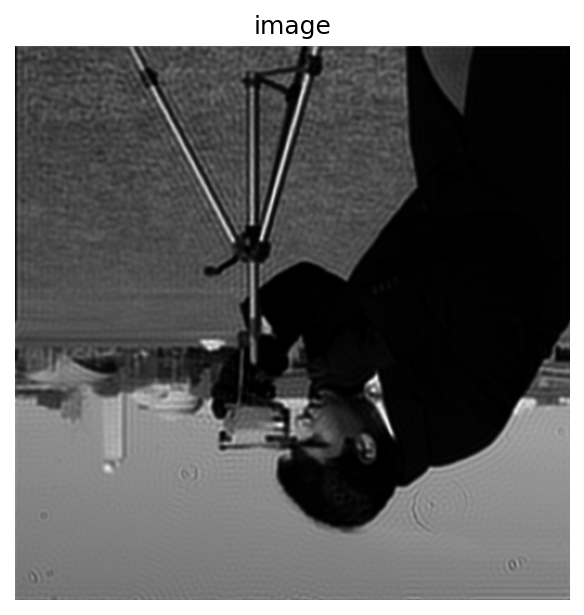

In [8]:
show_image(images[60].squeeze())

This should look like the amplitude sample, but with some "shadows" coming from the larger tilt of the illumination giving you some phase contrast.

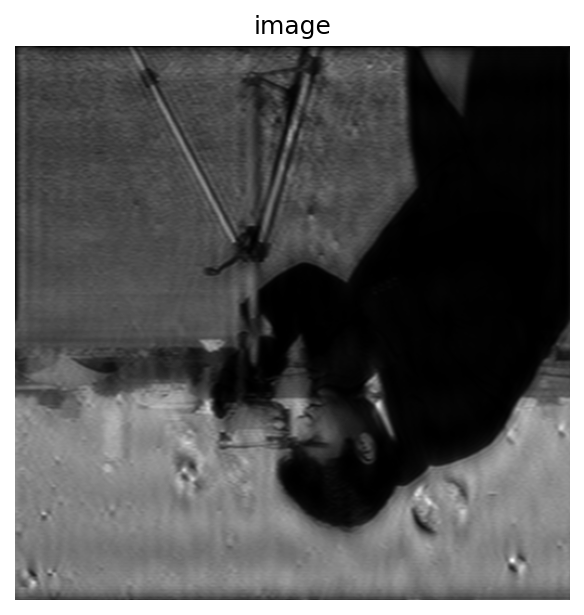

In [9]:
show_image(images[65].squeeze())

This should look like a dark field image of the sample, i.e. most of the amplitude of the sample (except the highest frequencies) should be missing from this image.

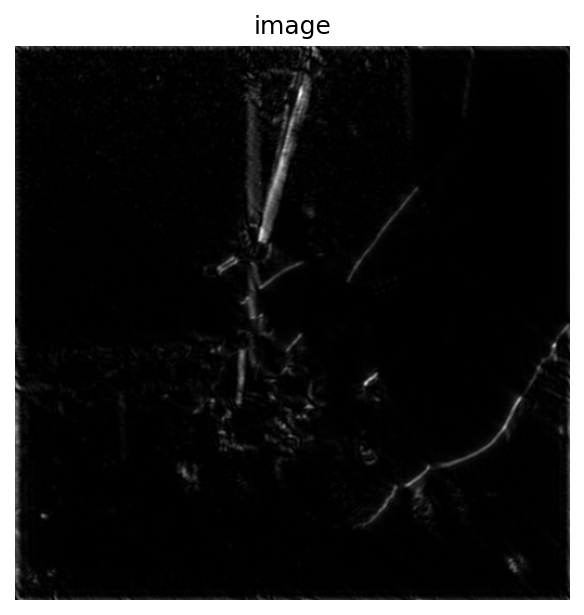

In [10]:
show_image(images[0].squeeze())

## Fourier Ptychography Reconstruction with Automatic Differentiation

Here, we want to reconstruct the complex sample (amplitude and phase) at a higher resolution than we measured. While we could do this in the traditional Gerchberg-Saxton style algorithm for Fourier ptychography, here we'll take advantage of the fact that Chromatix is fully differentiable to perform this optimization. The hard part is already done, since we defined the forward model above!

Now all we need to do is to define a loss function (mean squared error) between the "measured" images and our simulations using a guess of the reconstruction, and then use gradient descent optimization to reconstruct the complex sample.

In [11]:
# We're initializing the parameters that we want to optimize, i.e. the amplitude and phase of the sample.
parameters = (images[60].squeeze()[::-1, ::-1], jnp.zeros_like(images[60].squeeze()))
# We also initialize an optimizer (in this case we're just performing gradient descent).
optimizer = optax.sgd(1e13)
opt_state = optimizer.init(parameters)

# This defines our loss function, and it takes in the parameters
# we want to take gradients with respect to as the first argument.
def loss_fn(parameters: Array, measured_image: Array, kykx: Array) -> Array:
    # 1. Extract the amplitude and phase from the parameters tuple.
    # Remember that the first element of the tuple is the amplitude and
    # the second element is the phase.
    amplitude = parameters[0]
    phase = parameters[1]
    # 2. Simulate imaging the amplitude and phase you just got using
    # the forward model we defined previously.
    simulated = tilted_illumination_system(amplitude, phase, kykx)
    # 3. Return the mean squared error between the simulated image of
    # our reconstruction and the "measured" image that we passed to
    # this loss function. WARNING: Make sure to squeeze the output of your
    # simulation! Otherwise you'll get weird broadcasting that creates a
    # huge array, giving you incorrect results and making things really slow.
    return jnp.mean((simulated.squeeze() - measured_image)**2)

# This defines the update step which computes the loss but also the gradient of the loss
# with respect to our parameters (i.e. our guess of the reconstructed sample). We then use
# that gradient and our optimizer to update our reconstruction.
@jax.jit
def step(parameters: tuple[Array, Array], opt_state: Any, image: Array, kykx: Array) -> tuple[tuple[Array, Array], Any]:
    loss, grads = jax.value_and_grad(loss_fn)(parameters, image, kykx)
    updates, opt_state = optimizer.update(grads, opt_state)
    parameters = optax.apply_updates(parameters, updates)
    return loss, parameters, opt_state

# We then run this update step multiple times over all 121 measured images in order to arrive at a reconstruction.
# We've chosen the learning rate for you so that this should appropriately converge if everything's gone right.
losses = []
for i in range(10):
    for j in range(kykx.shape[0]):
        loss, parameters, opt_state = step(parameters, opt_state, images[j].squeeze(), kykx[j])
        losses.append(np.array(loss))
    print(f"iteration {i + 1} loss = {np.mean(np.array(losses[-1:-kykx.shape[0]:-1]))} over {kykx.shape[0]} images")

iteration 1 loss = 1.8397162959704616e-10 over 121 images
iteration 2 loss = 6.692488143528186e-12 over 121 images
iteration 3 loss = 8.807265355383065e-13 over 121 images
iteration 4 loss = 7.475833645707863e-13 over 121 images
iteration 5 loss = 6.836555518745235e-13 over 121 images
iteration 6 loss = 6.424971774228461e-13 over 121 images
iteration 7 loss = 6.116539024401957e-13 over 121 images
iteration 8 loss = 5.859819465596494e-13 over 121 images
iteration 9 loss = 5.633975274157987e-13 over 121 images
iteration 10 loss = 5.431252778249906e-13 over 121 images


If everything's gone right, you should see a converging loss plot below! This shows you the average loss across all 121 images at each iteration of our optimization.

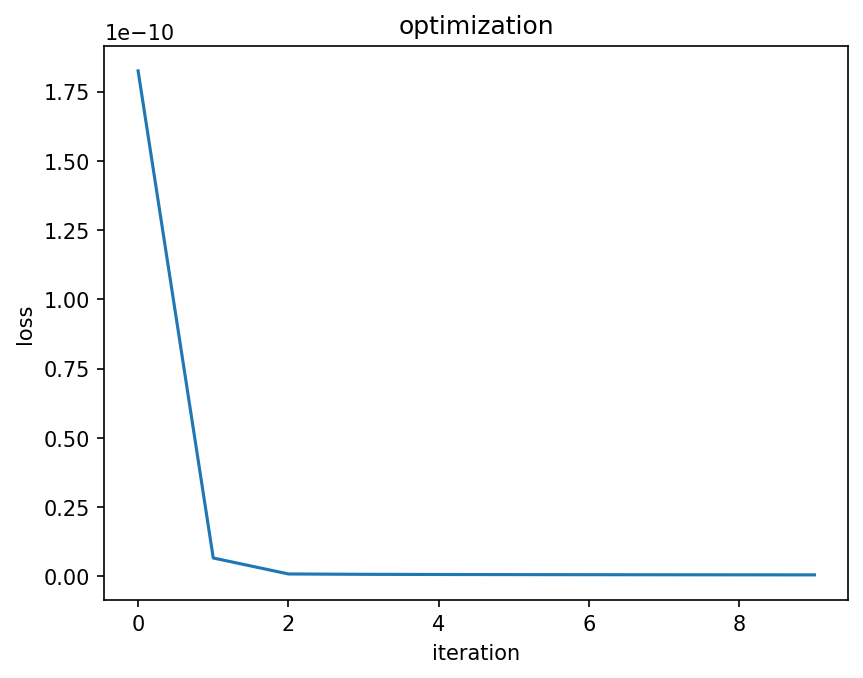

In [12]:
plot_losses(losses, 10)

And finally you should see our recovered reconstruction! You'll note that there are some artifacts... but we got a higher resolution reconstruction of the amplitude (look at the details on the hair, grass, or buttons), and an estimate of the phase of the sample.

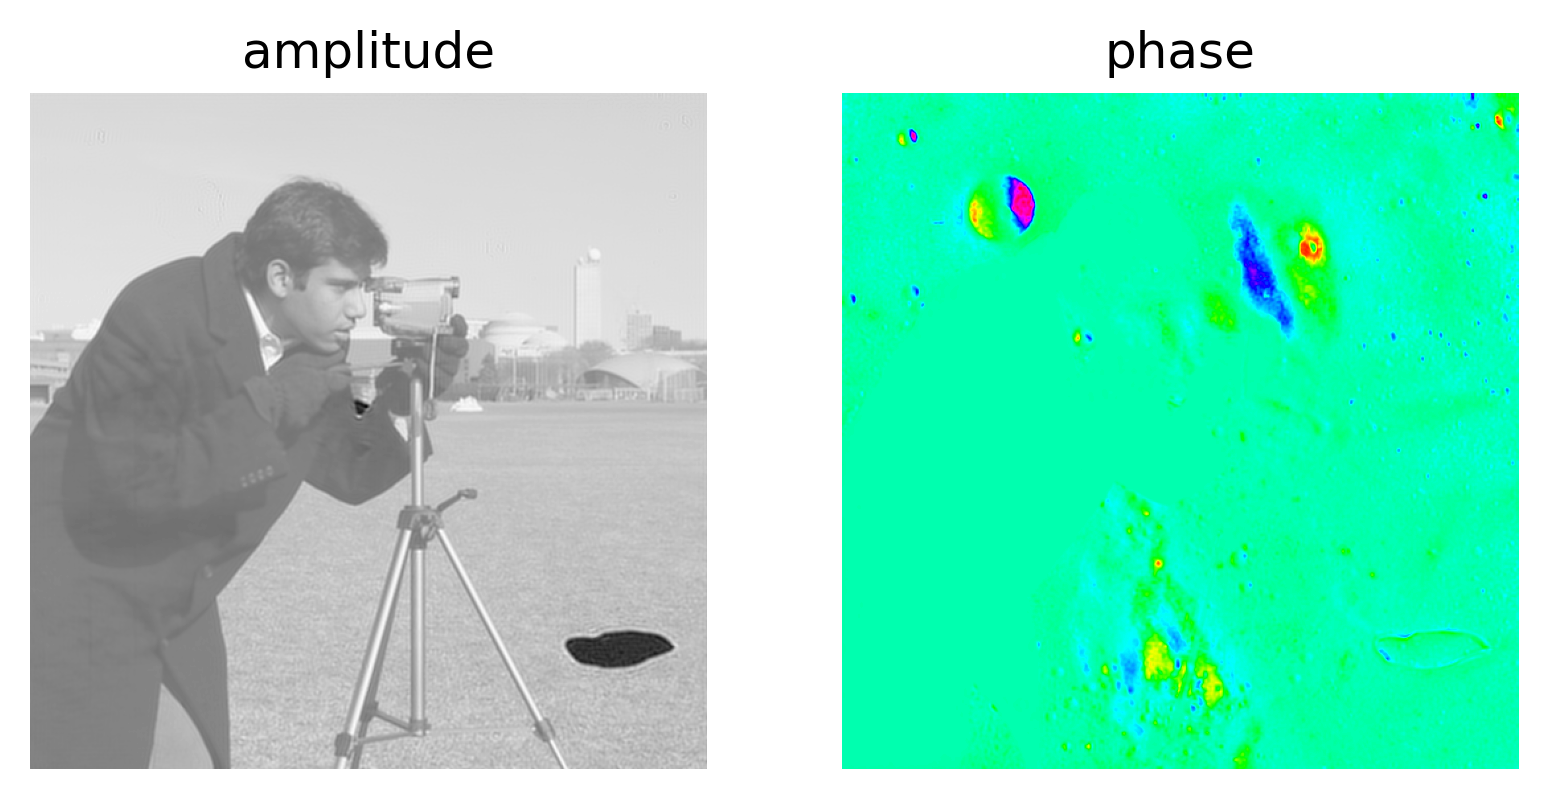

In [13]:
show_amplitude_and_phase(*parameters)

## Extensions

If you want to continue working on this demo:

1. The reconstruction above has significant artifacts. Can you play with either the angles of illumination or the optimization to improve these artifacts?
2. You can try to [install Chromatix](https://chromatix.readthedocs.io/en/latest/installing/) on your own computer with a bigger GPU and try out your own optimizations at a bigger scale than this simple demo.